# Imports

In [1]:
# Math
import torch
import numpy as np

# Flair Device
import flair
flair.device = torch.device('cpu')

# Analysis
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

# Downloading Packages
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Autoencoder and Dataset Preparation
from data.imdb_preparation import IMDB_preparation
from data.ag_news_preparation import AG_NEWS_preparation
from autoencoders.autoencoder import Autoencoder

[nltk_data] Downloading package punkt to /home/bodo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bodo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/bodo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/bodo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/bodo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. VAE

## 2.1 Loading Data

In [4]:
ds = AG_NEWS_preparation()
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)

Preparing sentences...


100%|██████████| 120000/120000 [04:37<00:00, 432.88it/s]


Making sentences...


100%|██████████| 120000/120000 [01:41<00:00, 1186.54it/s]


Embedding sentences...


100%|██████████| 120000/120000 [00:47<00:00, 2549.27it/s]


Splitting sentences...


100%|██████████| 120000/120000 [00:05<00:00, 22104.12it/s]

Done!


In [8]:
ds_train, ds_valid = torch.utils.data.random_split(ds, [len(ds) - 1000, 1000])
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, shuffle=True)

## 2.2 Training loop

In [11]:
torch.cuda.empty_cache()

In [12]:
m = Autoencoder(100,100,100,4,3,variational=True,max_log2len=8)
Lsmse = []
Lsvar = []
Ls_train = []
Ls_valid = []
device = 'cuda'
m = m.to(device)

In [13]:
opt = torch.optim.Adamax(m.parameters(), lr=0.001, weight_decay=0.0001)

In [14]:
EPOCHS = 10
beta = 0.1
for e in range(EPOCHS):
    print(f"Epoch: {e}")
    pbar = tqdm(dl_train)
    m = m.train()
    for i, (x_in, x_out) in enumerate(pbar):
        opt.zero_grad()
        x_in = x_in.to(device)
        x_out = x_out.to(device)
        mx, (mu, logvar) = m(x_in, return_Z=True)
        Lmse = (mx - x_out).pow(2).sum((1,2)).mean()
        Lvar = - 0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum((1,2)).mean()
        L = Lmse + beta*Lvar
        L.backward()
        opt.step()
    
        pbar.set_description(f"L: {L.item()} Lmse: {Lmse.item()} Lvar: {Lvar.item()}")
        
        Lsmse.append(Lmse.item())
        Lsvar.append(Lvar.item())
        Ls_train.append(L.item())
    with torch.no_grad():
        m = m.eval()
        pbar = tqdm(dl_valid)
        for i, (x_in, x_out) in enumerate(pbar):
            x_in = x_in.to(device)
            x_out = x_out.to(device)
            mx = m(x_in)
            L = (mx - x_out).pow(2).sum((1,2)).mean()
            pbar.set_description(f"VL: {L.item()}")
            Ls_valid.append(L.item())

torch.save(({'train': Ls_train, 'valid':Ls_valid, 'mse': Lsmse, 'var': Lsvar}, m.state_dict()), f'/content/drive/MyDrive/learning-nlp/model_epoch_{e}')



Epoch: 0


L: 246.62997436523438 Lmse: 243.20248413085938 Lvar: 34.27486038208008: 100%|██████████| 9350/9350 [08:48<00:00, 17.68it/s]
VL: 279.5192565917969: 100%|██████████| 32/32 [00:00<00:00, 51.40it/s]


Epoch: 1


L: 224.02503967285156 Lmse: 220.29014587402344 Lvar: 37.34900665283203: 100%|██████████| 9350/9350 [08:24<00:00, 18.52it/s]
VL: 253.89215087890625: 100%|██████████| 32/32 [00:00<00:00, 49.82it/s]


Epoch: 2


L: 218.23472595214844 Lmse: 214.0127410888672 Lvar: 42.219818115234375: 100%|██████████| 9350/9350 [08:32<00:00, 18.26it/s]
VL: 233.41696166992188: 100%|██████████| 32/32 [00:00<00:00, 51.57it/s]


Epoch: 3


L: 253.9893341064453 Lmse: 250.1442108154297 Lvar: 38.45124435424805: 100%|██████████| 9350/9350 [08:28<00:00, 18.38it/s]
VL: 224.41343688964844: 100%|██████████| 32/32 [00:00<00:00, 50.04it/s]


Epoch: 4


L: 234.60836791992188 Lmse: 230.11863708496094 Lvar: 44.89730453491211: 100%|██████████| 9350/9350 [08:17<00:00, 18.78it/s]
VL: 238.46881103515625: 100%|██████████| 32/32 [00:00<00:00, 52.56it/s]


Epoch: 5


L: 224.47952270507812 Lmse: 220.1431121826172 Lvar: 43.36414337158203: 100%|██████████| 9350/9350 [08:28<00:00, 18.38it/s]
VL: 222.205810546875: 100%|██████████| 32/32 [00:00<00:00, 51.71it/s]


Epoch: 6


L: 232.09674072265625 Lmse: 228.0510711669922 Lvar: 40.456642150878906: 100%|██████████| 9350/9350 [08:38<00:00, 18.03it/s]
VL: 219.26373291015625: 100%|██████████| 32/32 [00:00<00:00, 46.81it/s]


Epoch: 7


L: 226.0221405029297 Lmse: 221.36741638183594 Lvar: 46.54726791381836: 100%|██████████| 9350/9350 [08:46<00:00, 17.75it/s]
VL: 218.9578399658203: 100%|██████████| 32/32 [00:00<00:00, 45.66it/s]


Epoch: 8


L: 226.07778930664062 Lmse: 221.4630126953125 Lvar: 46.1477165222168: 100%|██████████| 9350/9350 [08:44<00:00, 17.84it/s]
VL: 196.6278076171875: 100%|██████████| 32/32 [00:00<00:00, 45.62it/s]


Epoch: 9


L: 251.28277587890625 Lmse: 246.8963165283203 Lvar: 43.86459732055664: 100%|██████████| 9350/9350 [08:49<00:00, 17.67it/s]
VL: 228.89926147460938: 100%|██████████| 32/32 [00:00<00:00, 46.07it/s]


For AG_NEWS dataset, the training curves look similar to the ones described in the IMDB section. The overall loss is mostly comprised of the MSE loss. The variational loss is much lower in comparison. The overall loss is being minimised very slowly.

The validation loss matches the training loss:

In [3]:
losses, _ = torch.load('training/AG_NEWS/model_epoch_9')

In [7]:
len(losses['valid'])

320

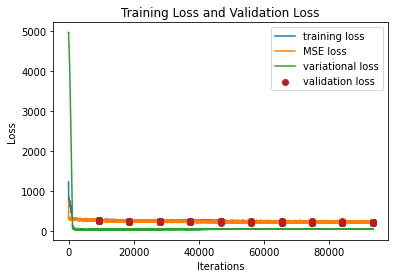

In [9]:
plt.plot(losses['train'], label='training loss')
plt.plot(losses['mse'], label='MSE loss')
plt.plot(losses['var'], label='variational loss')
for i in range(10):
    plt.scatter(
        [(i+1)*9349 for _ in range(32)],
        losses['valid'][i*32:(i+1)*32],
        zorder=2,
        c='firebrick',
        label='validation loss' if i == 0 else ''
    )
plt.title('Training Loss and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()